# Manual

In [1]:
# Set hyperparameters
encoding_size = 512
hidden_size = 512
num_layers = 1
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Set paths

model_path = './models/vae_gru/epoch_150.pt'

val_dataset_path = './models/vae_gru/val_dataset.parquet'

# Set number of molecules to generate

n_molecules = 40

# Load model

In [2]:
from gru.vae_gru import EncoderDecoder
from gru.dataset import GRUDataset
import selfies as sf
import rdkit.Chem as Chem
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from vectorizer import SELFIESVectorizer, determine_alphabet
import gc

gc.collect()
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'

In [3]:
# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

#model.load_state_dict(torch.load('PATH'))
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [7]:
def get_predictions(val_dataset_path, n_molecules, shuffle=False):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    alphabet = pd.read_csv('./GRU_data/alphabet.txt', header=None)[0].values.tolist()
    vectorizer = SELFIESVectorizer(alphabet, pad_to_len=128)

    val_df = pd.read_parquet(val_dataset_path).reset_index().drop(columns='index')
    val_dataset = GRUDataset(val_df, vectorizer)

    from torch.utils.data import DataLoader
    batch_size = 100
    val_loader = DataLoader(val_dataset, shuffle=shuffle, batch_size=batch_size, drop_last=True)

    x, y = next(iter(val_loader))
    x = x.to(device)
    y = y.to(device)
    preds = model(x, y, teacher_forcing=False)
    preds = preds.detach().cpu().numpy()
    targets = y.detach().cpu().numpy()
    fps = val_df.fps.apply(eval).tolist()
    
    pred_ms = []
    target_ms = []
    
    pred_selfies = []
    target_selfies = []
    
    for n in range(n_molecules):
        selfie_pred = vectorizer.devectorize(preds[n], remove_special=True)
        selfie_target = vectorizer.devectorize(targets[n], remove_special=True)
        pred_selfies.append(selfie_pred)
        target_selfies.append(selfie_target)
        try:
            smiles_pred = sf.decoder(selfie_pred)
        except:
            smiles_pred = 'C'
        smiles_target = sf.decoder(selfie_target)

        pred_ms.append(Chem.MolFromSmiles(smiles_pred))
        target_ms.append(Chem.MolFromSmiles(smiles_target))
    
    return target_ms, pred_ms, target_selfies, pred_selfies, fps

In [8]:
class Highlighter():
    
    def __init__(self, target_ms, pred_ms, fps):
        self.target_ms = target_ms
        self.pred_ms = pred_ms
        self.fps = fps
        self.key = pd.read_csv('KlekFP_keys.txt', header=None, names=['smarts']).smarts.values
        
    def __call__(self, k, fp_bit):
        target_mol, pred_mol = self.prepare_molecules(k)
        substruct = self.prepare_substruct(fp_bit)
        target_hits = list(target_mol.GetSubstructMatch(substruct))
        pred_hits = list(pred_mol.GetSubstructMatch(substruct))
        
        custom_legends = [f'target #{k}', 'predicted']
        return(Chem.Draw.MolsToGridImage([target_mol, pred_mol],
                                         molsPerRow=2,
                                         highlightAtomLists = [target_hits, pred_hits],
                                         legends = custom_legends,
                                         subImgSize=(400,400),
                                         returnPNG=False,
                                         useSVG=False))
        
    def prepare_molecules(self, k):
        target_mol = self.target_ms[k]
        pred_mol = self.pred_ms[k]
        return target_mol, pred_mol
    
    def prepare_substruct(self, fp_bit):
        substruct_mol = Chem.MolFromSmarts(self.key[fp_bit])
        return substruct_mol

In [9]:
import os

target_ms, pred_ms, target_selfies, pred_selfies, fps = get_predictions(val_dataset_path, 
                                                                       n_molecules=n_molecules, shuffle=True)
highlighter = Highlighter(target_ms, pred_ms, fps)

"""for k in range(len(target_ms)):
    os.mkdir(f'./imgs/{k}')
    for fp_bit in highlighter.fps[k]:
        img = highlighter(k, fp_bit)
        img.save(f'./imgs/{k}/{fp_bit}.png')"""

"for k in range(len(target_ms)):\n    os.mkdir(f'./imgs/{k}')\n    for fp_bit in highlighter.fps[k]:\n        img = highlighter(k, fp_bit)\n        img.save(f'./imgs/{k}/{fp_bit}.png')"

Target SELFIES:
[C][O][C][=C][C][=C][Branch1][#C][N][C][C][=C][N][=C][Branch1][C][N][N][=C][Ring1][#Branch1][N][C][=C][Ring1][S][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]

 Predicted SELFIES:
[C][O][C][=C][C][=C][Branch2][Ring1][Ring1][Branch1][C][C][=N][C][=C][C][C][N][N][=C][C][C][N][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring2][C][C][=C][=C][Ring1][Ring1][Ring1][=Branch1][C][=C][C][=C][=C][C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring2][C][=Branch1][C][=C][=C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C

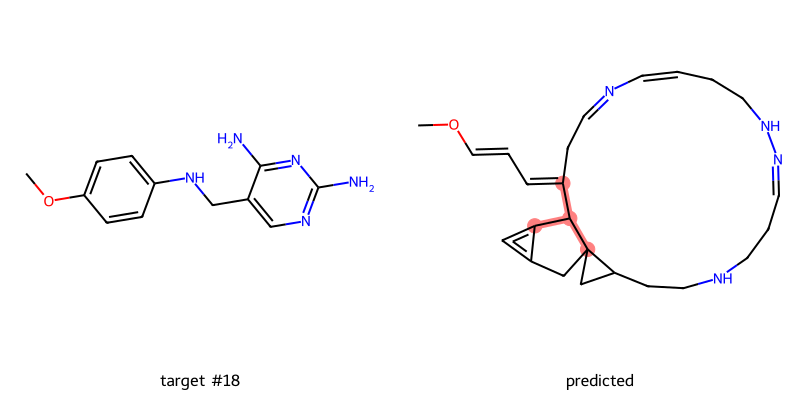

In [22]:
t = 18

print('Target SELFIES:')
print(target_selfies[t])
print('\n', 'Predicted SELFIES:')
print(pred_selfies[t])
highlighter(t,0)